# Importing Snapshots from OpenFOAM

**Aim of this notebook:** learn how to import transient snapshots from OpenFOAM (version 2012 from com-version) using *pyvista* package.

The snapshots are related to the laminar Flow Over Cylinder in fluid dynamics, governed by the Navier-Stokes equations. In particular, the snapshots have been generated using the tutorial case reported [here](https://develop.openfoam.com/Development/openfoam/-/tree/OpenFOAM-v2012/tutorials/incompressible/pimpleFoam/laminar/cylinder2D).
Furthermore, some features of the *pyvista* package are shown, including plotting and data manipulation.

The data are available on Zenodo, change the folder name to `OF_case` or change the path in the code below.

The class `ReadFromOF` is used to read the OpenFOAM snapshots, create a mesh for *dolfinx* and plot the results using *pyvista*.

In [1]:
from pyforce.tools.write_read import ReadFromOF

of = ReadFromOF('OF_case/')

/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/ufl/__init__.py:244: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


The case contains an `UnstructuredGrid` element containing the fields `U`, `p`. The default time step is `0`, but you can change it to any other time step available in the case.

In [2]:
of.reader.read()

MultiBlock (0x339db7ca0)
  N Blocks    2
  X Bounds    -0.608, 1.120
  Y Bounds    -0.600, 0.600
  Z Bounds    -0.007, 0.007

The time instants saved can be printed

In [3]:
import numpy as np

times = np.array(of.reader.time_values)
print('Time values:', times)

Time values: [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256. 258. 260. 262. 264. 266. 268. 270. 272. 274. 276. 278.
 280. 282. 284. 286. 288. 290. 292. 294. 296. 298. 300. 302. 304. 306.
 308. 310. 312. 314. 316. 318. 320. 322. 324. 326. 328. 330. 332. 334.
 336. 338. 340. 342. 344. 346. 348. 350. 352. 354. 356. 358. 360. 362.
 364. 366. 368. 370. 372. 374. 376. 378. 380. 382. 384. 386. 388

In `internalMesh`, the fields are saved as point data or cell data, which can be used for plotting.

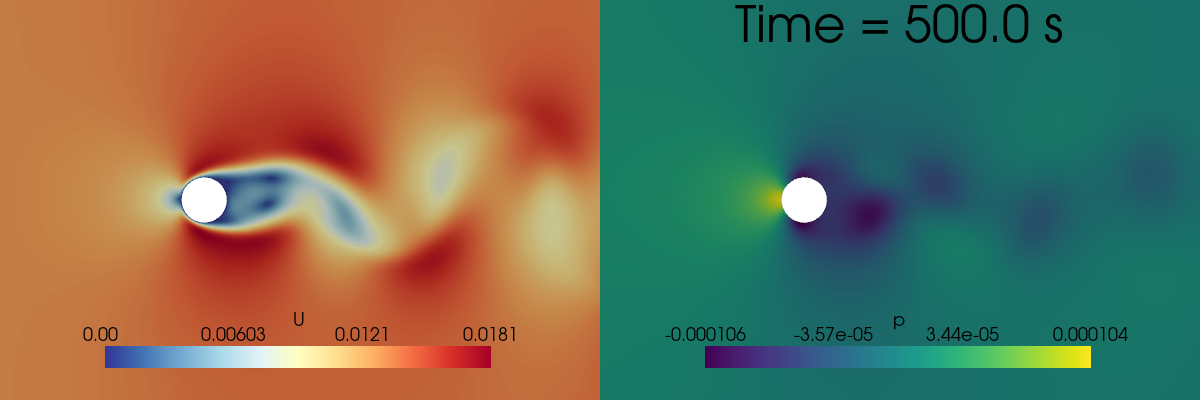

In [4]:
import pyvista as pv
from IPython.display import clear_output as clc

dict_cb = dict( width = 0.65, height = 0.15,
                    n_labels=4,
                    color = 'k',
                    position_x=0.175, position_y=0.0785,
                    shadow=False) 

tt = len(of.reader.time_values)-1

of.reader.set_active_time_value(of.reader.time_values[tt])
mesh = of.reader.read()['internalMesh']

pl = pv.Plotter(shape=(1, 2), border=False, off_screen=True, window_size=(1200, 400))

pl.subplot(0,0)
pl.add_mesh(mesh.slice(normal='z'), scalars='U', cmap='RdYlBu_r', scalar_bar_args=dict_cb)

pl.subplot(0,1)
pl.add_mesh(mesh.slice(normal='z'), scalars='p', cmap='viridis', scalar_bar_args=dict_cb)

for i in range(2):
    pl.subplot(0, i)
    pl.view_xy()
    pl.camera.zoom(2)

pl.add_text(f'Time = {of.reader.time_values[tt]} s', position='upper_edge', font_size=20, color='k')
pl.show(jupyter_backend='static')

Let us import the velocity and pressure fields from the OpenFOAM case.

In [5]:
var_names = ['U', 'p']
vector = [True, False]

of_snaps = dict()
for field_i, field in enumerate(var_names):
    of_snaps[field] = np.asarray(of.import_field(field, vector=vector[field_i])[0])

Importing U using pyvista
Importing p using pyvista


Let us add also the vorticity field, defined as the curl of the velocity field, $\boldsymbol{\omega} = \nabla \times \mathbf{u}$.

In [6]:
from pyforce.tools.backends import LoopProgress

var_names.append('vorticity')
vector.append(True)

of_snaps['vorticity'] = np.zeros_like(of_snaps['U'])

bar = LoopProgress(msg='Computing vorticity', final =of_snaps['U'].shape[0])
for tt in range(of_snaps['U'].shape[0]):

    of.reader.set_active_time_value(of.reader.time_values[tt])
    mesh = of.reader.read()['internalMesh']
    of_snaps['vorticity'][tt] = mesh.compute_derivative(scalars='U', vorticity=True)['vorticity']

    bar.update(1)


Computing vorticity: 250.000 / 250.00 - 0.215 s/it


Let us make a plot of the vorticity field using *pyvista*.

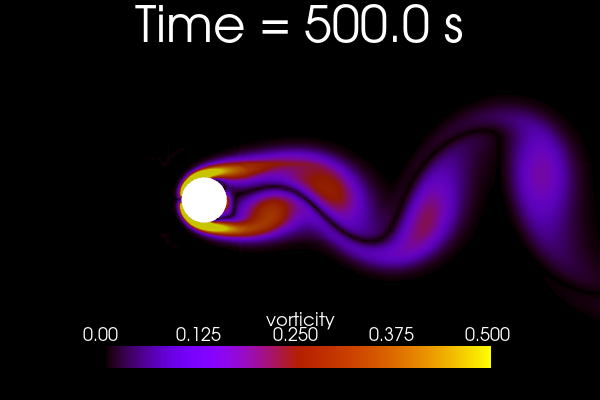

In [18]:
dict_cb = dict( width = 0.65, height = 0.15,
                    n_labels=5,
                    color = 'white',
                    position_x=0.175, position_y=0.0785,
                    shadow=False) 

tt = len(of_snaps['vorticity']) - 1

mesh = of.reader.read()['internalMesh']

mesh['vorticity'] = of_snaps['vorticity'][tt]

pl = pv.Plotter(window_size=(600, 400))
pl.add_mesh(mesh.slice(normal='z'), scalars='vorticity', cmap='gnuplot', scalar_bar_args=dict_cb, clim=(0,0.5))

pl.view_xy()
pl.camera.zoom(2)

pl.add_text(f'Time = {of.reader.time_values[tt+1]} s', position='upper_edge', font_size=20, color='white')

pl.show(jupyter_backend='static')

Let us save the snapshots in a `npz` file for later use.

In [23]:
path_snaps = 'Snapshots/'
import os
os.makedirs(path_snaps, exist_ok=True)

np.savez_compressed(path_snaps+'of_dataset.npz', snaps=of_snaps, time_values=times[1:], is_vector=vector, var_names=var_names)

Let us store also the mesh in a `vtk` file for later use.

In [27]:
mesh = of.reader.read()['internalMesh']
mesh.clear_data()
mesh.save(path_snaps+'of_mesh.vtk')